###### 전처리

In [1]:
import pandas as pd
import matplotlib as mpl
import datetime
from datetime import date
import holidays
import matplotlib.pyplot as plt

corona=pd.read_csv('./DATA/002_2.COVID-19.csv', encoding='utf-8', parse_dates=['DATE'])
subway=pd.read_csv('./DATA/002_1.DAILY_SUBWAY_INFO.csv', encoding='utf-8', parse_dates=['date'])
step=pd.read_csv('./DATA/001_3.CSV_SOCIAL_DISTANCE_STEP.csv', encoding='utf-8', parse_dates=['date'])

# df : DataFrame
# df.index : datetime64 type
# start, end : str('YYYY-MM-DD')
def slicing(df, start, end):
    dateRange = pd.date_range(start, end)
    return df[df['date'].isin(dateRange)]

# 일일 확진자 수 전처리
corona['DATE']= corona['DATE'].astype('str')
corona['DATE'] = pd.to_datetime(corona['DATE'])
corona.rename(columns= {'ID' : 'corona'}, inplace=True)
coro_seoul = corona.groupby(['DATE']).count()
coro_seoul.insert(0, 'date', coro_seoul.index)
coro_seoul = coro_seoul[{'date', 'corona'}]


# 전철 이용자 수 전처리 (2019-01-01 ~ 2021-07-31)
subway['date']= subway['date'].astype('str')
subway['date'] = pd.to_datetime(subway['date'])

# 거리두기단계 전처리
step['date']= step['date'].astype('str')
step['date'] = pd.to_datetime(step['date'])

# df에 coro_seoul, subway 합치기
df = pd.merge(subway, coro_seoul, how='outer', on='date')
df = df.fillna(0)
# df['corona'] = df['corona'].astype('Int64')
# df['total'] = df['total'].astype('Int64')

# df에 step 합치기
df = pd.merge(df, step, how='outer', on='date')
df.columns = ['date', 'on_num', 'off_num', 'total', 'corona', 'step']
df = df.fillna(0)

df['total'].astype('float64')
df['corona'].astype('float64')

# df_biz : Business day (법정공휴일, 주말 제외)
holidays = holidays.Korea()
datetime.date(2019, 1, 1) in holidays
datetime.date(2020, 1, 1) in holidays
datetime.date(2021, 1, 1) in holidays
df_biz = df[~df['date'].isin(list(holidays.keys()))]
df_biz = df_biz[df_biz['date'].dt.dayofweek < 5].copy()
df_biz = df_biz.set_index('date')
df = df.set_index('date')

# df_week : 주 단위로 묶기 (평균, 합계, 합계)
df_week = pd.DataFrame()
df_week['total'] = df_biz['total'].resample('7D').mean()
df_week['corona'] = df_biz['corona'].resample('7D').sum()
df_week['on_num'] = df_biz['on_num'].resample('7D').sum()
df_week['step'] = df_biz['step'].resample('7D').max()

df_week=df_week.reset_index()

###### 시각화

년월일을 2회 입력하여
그래프에 나타낼 날짜 범위를 설정하세요.
형식: 'YYYY-MM-DD'
시작 날짜:'2020-01-01'
끝 날짜:'2020-07-01'
변수를 2회 입력하여 그래프에 나타낼 변수를 설정하세요.
변수 목록: 1.확진자 수 2.전철이용자 수 3.거리두기 단계
숫자 한 개 씩 2회 입력
변수1:2
변수2:3

'2020-01-01'부터 '2020-07-01'까지
주간 전철이용자 수와 주간 거리두기 단계의 상관계수: -0.9


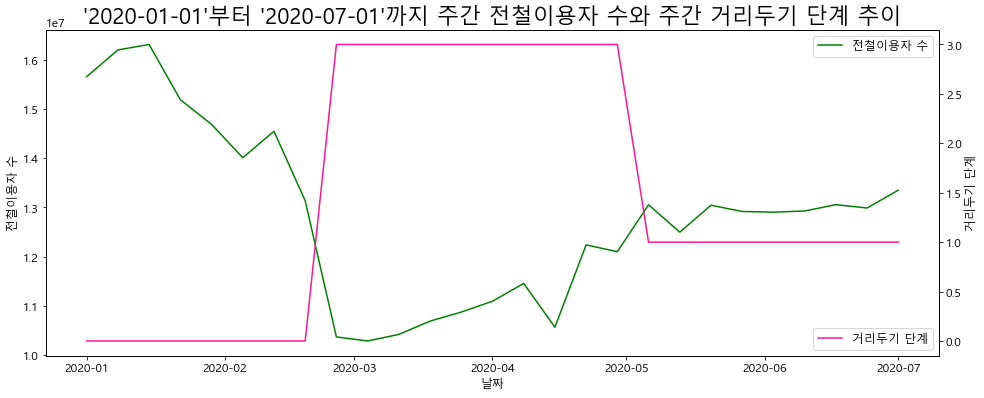

In [5]:
# 시간 범위 입력 받기
print("년월일을 2회 입력하여\n그래프에 나타낼 날짜 범위를 설정하세요.\n형식: 'YYYY-MM-DD'")
start=input('시작 날짜:')
end=input('끝 날짜:')
df_temp=slicing(df_week,start,end)

# 변수 2개 입력 받기
feat_map={1:'corona',2:'total',3:'step'}
label_map={1:'확진자 수',2:'전철이용자 수',3:'거리두기 단계'}
print("변수를 2회 입력하여 그래프에 나타낼 변수를 설정하세요.")
print("변수 목록: 1.확진자 수 2.전철이용자 수 3.거리두기 단계")
print("숫자 한 개 씩 2회 입력")
a=int(input('변수1:'))
b=int(input('변수2:'))
feat1=feat_map[a]
feat2=feat_map[b]
label1=label_map[a]
label2=label_map[b]

# 그래프 그리기
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['font.size'] = 12
plt.rc('font', family='Malgun Gothic')

fig, ax1 = plt.subplots()
ax1.plot(df_temp['date'],df_temp[feat1], color='green', label=label1)
ax1.set_xlabel('날짜')
ax1.set_ylabel(label1)
ax1.legend(loc='upper right')

ax2 = ax1.twinx()
ax2.set_ylabel(label2)
ax2.plot(df_temp['date'],df_temp[feat2], color='deeppink', label=label2)
ax2.legend(loc='lower right')
plt.title('{0}부터 {1}까지 주간 {2}와 주간 {3} 추이'.format(start,end,label1,label2), size=22)

corr=df_temp.corr()
print('\n{0}부터 {1}까지\n주간 {2}와 주간 {3}의 상관계수:'.format(start,end,label1,label2), round(corr[feat1][feat2],3))

import warnings
warnings.filterwarnings('ignore')